In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read the CSV file
df = pd.read_csv('ANON36_MACE_EKG_output.csv')

# change variable names
df = df.rename(columns={
    'Risk- Hypertension' : 'Hypertension',
    'Risk- Hypercholesteremia' : 'Hypercholesteremia', 
    'Risk- Hypertriglyceridemia' : 'Hypertriglyceridemia',
    'Risk- High HDL' : 'High HDL', 
    'Risk- Low HDL' : 'Low HDL', 
    'Risk- Diabetes' : 'Diabetes', 
    'Risk- Family Hx' : 'Family Hx',
    'Risk- Smoke' : 'Smoke', 
    'ASCVD PCE Risk Score' :'ASCVD PCE Risk',
    'PREVENT Score - ASCVD 10-year risk' : 'PREVENT ASCVD Risk', 
    'CVD PREVENT 10yr' : 'PREVENT CVD Risk',
    'HF PREVENT 10-year' : 'PREVENT HF Risk', 
    'Total A' : 'Total CAC Score', 
    'LM A' : 'CAC Score (Left Main)', 
    'LAD A' : 'CAC Score (LAD)', 
    'Cx' : 'CAC Score (LCx)', 
    'RCA' : 'CAC Score (RCA)',
    'Num Lesions' : 'Number of Total Lesions', 
    'Lesion Vol Sum' : 'Total Volume Score', 
    'Lesion Max D' : 'Peak CAC Density', 
    'Lesion Ave D' : 'Mean CAC Density', 
    'Male' : 'Gender',
    'Race_encoded' : 'Race',
})

In [4]:
# Select the columns
X = df.drop(['CONFIRM ID', 'result'], axis=1)
y = df['result']

# Make some columns categorical
categorical_cols = [X.columns[i] for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,45]]
for col in categorical_cols:
    X[col] = X[col].astype('category')

In [5]:
# Initialize StratifiedKFold for 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

# Create the XGBClassifier
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)

# Placeholder for the stacked probabilities
stacked_probabilities = np.zeros(y.shape)

# List to hold AUC scores for each fold
auc_scores = []

# Cross-validation loop
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    stacked_probabilities[test_index] = y_pred_proba
    
    # Calculate AUC for the current fold
    fold_auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(fold_auc)

In [6]:
# Create a DataFrame with actual outcomes and predicted probabilities
output_df = pd.DataFrame({
    'Actual Outcome': y,  # Real outcome (0 or 1)
    'Predicted Probability': stacked_probabilities  # Probability of class 1
})

# Save the DataFrame to a CSV file
# output_df.to_csv('predicted_probabilities_with_actuals.csv', index=False)

# Display the first few rows
print(output_df)

       Actual Outcome  Predicted Probability
0                   0               0.000083
1                   0               0.013772
2                   0               0.000568
3                   0               0.015657
4                   0               0.000332
...               ...                    ...
27203               0               0.000224
27204               0               0.119581
27205               0               0.004878
27206               0               0.007418
27207               0               0.028469

[27208 rows x 2 columns]


Plot histogram of log-transformed probabilities

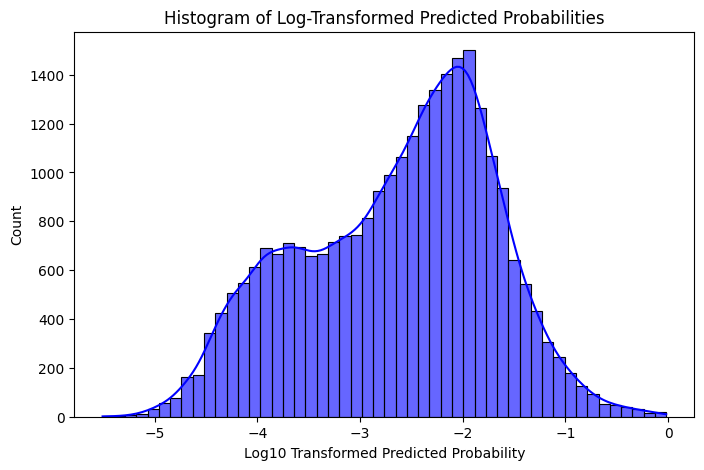

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Avoid log(0) by adding a small constant (e.g., 1e-6)
output_df['Log Predicted Probability'] = np.log10(output_df['Predicted Probability'] + 1e-6)

# Plot histogram of log-transformed probabilities
plt.figure(figsize=(8, 5))
sns.histplot(output_df['Log Predicted Probability'], bins=50, kde=True, color='blue', alpha=0.6)
plt.xlabel("Log10 Transformed Predicted Probability")
plt.ylabel("Count")
plt.title("Histogram of Log-Transformed Predicted Probabilities")
plt.show()

In [31]:
print(output_df)

       Actual Outcome  Predicted Probability  Log Predicted Probability
0                   0               0.000083                  -4.075741
1                   0               0.013772                  -1.860982
2                   0               0.000568                  -3.245085
3                   0               0.015657                  -1.805271
4                   0               0.000332                  -3.477583
...               ...                    ...                        ...
27203               0               0.000224                  -3.647144
27204               0               0.119581                  -0.922334
27205               0               0.004878                  -2.311628
27206               0               0.007418                  -2.129648
27207               0               0.028469                  -1.545615

[27208 rows x 3 columns]


For the predicted probabilities:

Identifies the two steepest rising slopes in the Kernel Density Estimate (KDE) of log-transformed predicted probabilities:

It splits the x-axis at -3.5 to isolate two wave-like regions. It then uses scipy.optimize.minimize_scalar to find the point of maximum positive slope in each region by maximizing the numerical derivative of the KDE. 

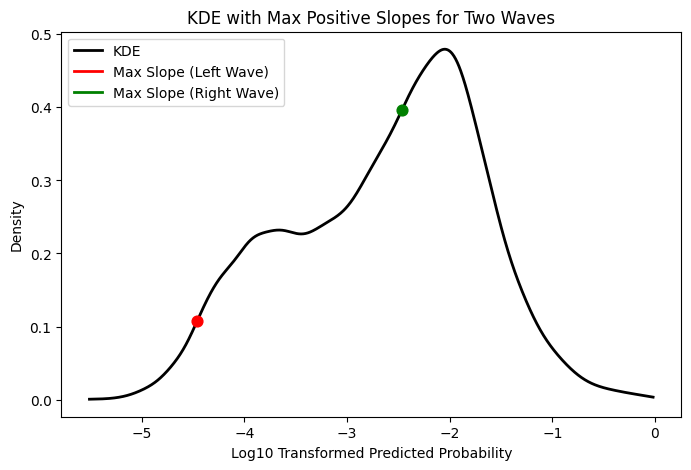

Left wave: max slope at x = -4.4582, slope ≈ 0.3130
Right wave: max slope at x = -2.4663, slope ≈ 0.2991


In [8]:
from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

log_probs = output_df['Log Predicted Probability'].values
kde = gaussian_kde(log_probs)

# Function that returns negative slope if positive, else penalize
def neg_pos_slope(x, dx=1e-4, slope_thresh=0.01):
    slope = (kde(x + dx)[0] - kde(x - dx)[0]) / (2 * dx)
    return -slope 

# Split point to isolate the two waves
x_split = -3.5

# Max positive slope in left wave
result_left = minimize_scalar(neg_pos_slope, bounds=(log_probs.min(), x_split), method='bounded')
x1 = result_left.x

# Max positive slope in right wave
result_right = minimize_scalar(neg_pos_slope, bounds=(x_split, -2), method='bounded')
x2 = result_right.x

dx = 1e-4
x1_start, x1_end = x1 - dx, x1 + dx
y1_start, y1_end = kde(x1_start)[0], kde(x1_end)[0]
y1_center = kde(x1)[0]

x2_start, x2_end = x2 - dx, x2 + dx
y2_start, y2_end = kde(x2_start)[0], kde(x2_end)[0]
y2_center = kde(x2)[0]

# Plotting
x_vals = np.linspace(log_probs.min(), log_probs.max(), 1000)
y_vals = kde(x_vals)

plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color='black', linewidth=2, label='KDE')

plt.plot([x1_start, x1_end], [y1_start, y1_end], 'r-', linewidth=2, label='Max Slope (Left Wave)')
plt.plot([x2_start, x2_end], [y2_start, y2_end], 'g-', linewidth=2, label='Max Slope (Right Wave)')

# Mark slope centers
plt.scatter(x1, y1_center, color='red', s=60, zorder=5)
plt.scatter(x2, y2_center, color='green', s=60, zorder=5)

plt.xlabel("Log10 Transformed Predicted Probability")
plt.ylabel("Density")
plt.title("KDE with Max Positive Slopes for Two Waves")
plt.legend()
plt.show()

slope1 = (y1_end - y1_start) / (2 * dx)
slope2 = (y2_end - y2_start) / (2 * dx)
print(f"Left wave: max slope at x = {x1:.4f}, slope ≈ {slope1:.4f}")
print(f"Right wave: max slope at x = {x2:.4f}, slope ≈ {slope2:.4f}")

Convert the log-transformation back to the original probability scale. 

In [9]:
def inverse_log_pred(log_pred):
    return 10**log_pred - 1e-6

original_prob_x1 = inverse_log_pred(x1)
original_prob_x2 = inverse_log_pred(x2)

print(f"Left wave (x1): log = {x1:.4f}, prob = {original_prob_x1:.6f}")
print(f"Right wave (x2): log = {x2:.4f}, prob = {original_prob_x2:.6f}")

Left wave (x1): log = -4.4582, prob = 0.000034
Right wave (x2): log = -2.4663, prob = 0.003416


Use this two values as cutoff thresholds to stratify data into Low, Moderate, and High Risk groups.

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from IPython.display import display

low_cutoff = original_prob_x1
high_cutoff = original_prob_x2

# Step 2: Apply risk grouping based on x1/x2 thresholds
output_df['Risk Group'] = output_df['Predicted Probability'].apply(
    lambda prob: "Low Risk" if prob < low_cutoff else ("Moderate Risk" if prob < high_cutoff else "High Risk")
)

# Step 3: Count samples per group
group_counts = output_df['Risk Group'].value_counts().to_dict()

# Step 4: Count events (Actual Outcome = 1) per group
event_counts = output_df.groupby('Risk Group')['Actual Outcome'].sum().to_dict()

# Step 5: Event rate within each group
event_percentages = {
    group: (event_counts.get(group, 0) / group_counts.get(group, 1)) * 100
    for group in ["Low Risk", "Moderate Risk", "High Risk"]
}

# Step 6: Compute AUC per group (only if both classes are present)
auc_per_group = {}
for group in ["Low Risk", "Moderate Risk", "High Risk"]:
    group_df = output_df[output_df['Risk Group'] == group]
    y_true = group_df['Actual Outcome']
    
    if len(group_df) > 50 and y_true.nunique() == 2:  # Must have both 0 and 1
        auc_per_group[group] = roc_auc_score(y_true, group_df['Predicted Probability'])
    else:
        auc_per_group[group] = None


# Step 7: Weighted average AUC
valid_aucs = {group: auc for group, auc in auc_per_group.items() if auc is not None}
total_samples = sum(group_counts.values())

if valid_aucs and total_samples > 0:
    weighted_auc = sum(
        (group_counts[group] * auc_per_group[group]) for group in valid_aucs
    ) / total_samples
else:
    weighted_auc = None

# Step 8: Store results in a DataFrame
final_cutoff_result = pd.DataFrame([{
    "Low Cutoff Value": low_cutoff,
    "High Cutoff Value": high_cutoff,

    "Low Risk AUC": auc_per_group["Low Risk"],
    "Low Risk Count": group_counts.get("Low Risk", 0),
    "Low Risk Event Count": event_counts.get("Low Risk", 0),
    "Low Risk Event %": event_percentages.get("Low Risk", 0),

    "Moderate Risk AUC": auc_per_group["Moderate Risk"],
    "Moderate Risk Count": group_counts.get("Moderate Risk", 0),
    "Moderate Risk Event Count": event_counts.get("Moderate Risk", 0),
    "Moderate Risk Event %": event_percentages.get("Moderate Risk", 0),

    "High Risk AUC": auc_per_group["High Risk"],
    "High Risk Count": group_counts.get("High Risk", 0),
    "High Risk Event Count": event_counts.get("High Risk", 0),
    "High Risk Event %": event_percentages.get("High Risk", 0),

    "Weighted AUC": weighted_auc
}])

# Display the results
display(final_cutoff_result)


,Low Cutoff Value,High Cutoff Value,Low Risk AUC,Low Risk Count,Low Risk Event Count,Low Risk Event %,Moderate Risk AUC,Moderate Risk Count,Moderate Risk Event Count,Moderate Risk Event %,High Risk AUC,High Risk Count,High Risk Event Count,High Risk Event %,Weighted AUC
0,0.000034,0.003416,None,691,0,0.0,0.750295,13127,96,0.731317,0.650619,13390,461,3.442868,0.682186


Identifies the two peak points in the Kernel Density Estimate (KDE) of log-transformed predicted probabilities:

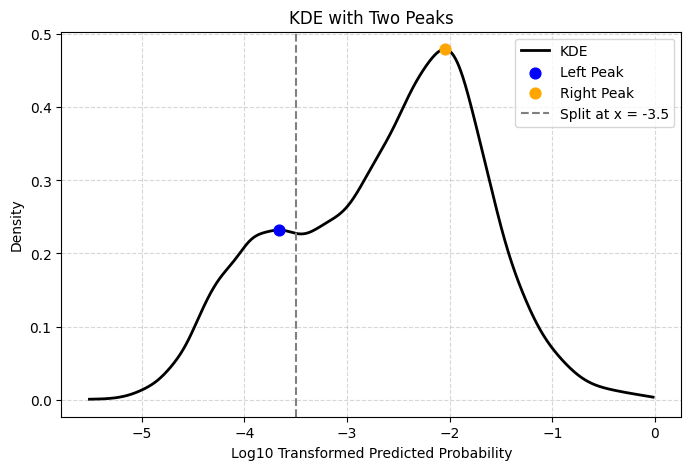

Left peak at x = -3.6622, density ≈ 0.2320
Right peak at x = -2.0463, density ≈ 0.4796


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# KDE estimation
log_probs = output_df['Log Predicted Probability'].values
kde = gaussian_kde(log_probs)

# Evaluate KDE on a fine grid
x_vals = np.linspace(log_probs.min(), log_probs.max(), 1000)
y_vals = kde(x_vals)

# First derivative of KDE (numerical)
dy = np.gradient(y_vals, x_vals)

# Split point
x_split = -3.5

# Find local maxima where derivative changes from + to -
peak_indices = np.where((np.hstack([dy[1:], 0]) < 0) & (np.hstack([0, dy[:-1]]) > 0))[0]

# Separate left and right peaks
left_peaks = [i for i in peak_indices if x_vals[i] < x_split]
right_peaks = [i for i in peak_indices if x_vals[i] >= x_split]

# Choose the highest peak in each region
idx_left_peak = left_peaks[np.argmax([y_vals[i] for i in left_peaks])]
idx_right_peak = right_peaks[np.argmax([y_vals[i] for i in right_peaks])]

x_left_peak, y_left_peak = x_vals[idx_left_peak], y_vals[idx_left_peak]
x_right_peak, y_right_peak = x_vals[idx_right_peak], y_vals[idx_right_peak]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color='black', linewidth=2, label='KDE')

# Mark peak points
plt.scatter(x_left_peak, y_left_peak, color='blue', s=60, zorder=5, label='Left Peak')
plt.scatter(x_right_peak, y_right_peak, color='orange', s=60, zorder=5, label='Right Peak')

plt.axvline(x_split, color='gray', linestyle='--', label='Split at x = -3.5')

plt.xlabel("Log10 Transformed Predicted Probability")
plt.ylabel("Density")
plt.title("KDE with Two Peaks")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print result
print(f"Left peak at x = {x_left_peak:.4f}, density ≈ {y_left_peak:.4f}")
print(f"Right peak at x = {x_right_peak:.4f}, density ≈ {y_right_peak:.4f}")


Convert back to original scale and use these two points as cutoff values.

In [12]:
original_left_peak = inverse_log_pred(x_left_peak)
original_right_peak = inverse_log_pred(x_right_peak)

print(f"Left peak: log = {x_left_peak:.4f}, prob = {original_left_peak:.6f}")
print(f"Right peak: log = {x_right_peak:.4f}, prob = {original_right_peak:.6f}")

Left peak: log = -3.6622, prob = 0.000217
Right peak: log = -2.0463, prob = 0.008987


In [13]:
low_cutoff = original_left_peak
high_cutoff = original_right_peak

# Step 2: Apply risk grouping based on x1/x2 thresholds
output_df['Risk Group'] = output_df['Predicted Probability'].apply(
    lambda prob: "Low Risk" if prob < low_cutoff else ("Moderate Risk" if prob < high_cutoff else "High Risk")
)

# Step 3: Count samples per group
group_counts = output_df['Risk Group'].value_counts().to_dict()

# Step 4: Count events (Actual Outcome = 1) per group
event_counts = output_df.groupby('Risk Group')['Actual Outcome'].sum().to_dict()

# Step 5: Event rate within each group
event_percentages = {
    group: (event_counts.get(group, 0) / group_counts.get(group, 1)) * 100
    for group in ["Low Risk", "Moderate Risk", "High Risk"]
}

# Step 6: Compute AUC per group (only if both classes are present)
auc_per_group = {}
for group in ["Low Risk", "Moderate Risk", "High Risk"]:
    group_df = output_df[output_df['Risk Group'] == group]
    y_true = group_df['Actual Outcome']
    
    if len(group_df) > 50 and y_true.nunique() == 2:  # Must have both 0 and 1
        auc_per_group[group] = roc_auc_score(y_true, group_df['Predicted Probability'])
    else:
        auc_per_group[group] = None


# Step 7: Weighted average AUC
valid_aucs = {group: auc for group, auc in auc_per_group.items() if auc is not None}
total_samples = sum(group_counts.values())

if valid_aucs and total_samples > 0:
    weighted_auc = sum(
        (group_counts[group] * auc_per_group[group]) for group in valid_aucs
    ) / total_samples
else:
    weighted_auc = None

# Step 8: Store results in a DataFrame
final_cutoff_result_3 = pd.DataFrame([{
    "Low Cutoff Value": low_cutoff,
    "High Cutoff Value": high_cutoff,

    "Low Risk AUC": auc_per_group["Low Risk"],
    "Low Risk Count": group_counts.get("Low Risk", 0),
    "Low Risk Event Count": event_counts.get("Low Risk", 0),
    "Low Risk Event %": event_percentages.get("Low Risk", 0),

    "Moderate Risk AUC": auc_per_group["Moderate Risk"],
    "Moderate Risk Count": group_counts.get("Moderate Risk", 0),
    "Moderate Risk Event Count": event_counts.get("Moderate Risk", 0),
    "Moderate Risk Event %": event_percentages.get("Moderate Risk", 0),

    "High Risk AUC": auc_per_group["High Risk"],
    "High Risk Count": group_counts.get("High Risk", 0),
    "High Risk Event Count": event_counts.get("High Risk", 0),
    "High Risk Event %": event_percentages.get("High Risk", 0),

    "Weighted AUC": weighted_auc
}])

# Display the results
display(final_cutoff_result_3)

,Low Cutoff Value,High Cutoff Value,Low Risk AUC,Low Risk Count,Low Risk Event Count,Low Risk Event %,Moderate Risk AUC,Moderate Risk Count,Moderate Risk Event Count,Moderate Risk Event %,High Risk AUC,High Risk Count,High Risk Event Count,High Risk Event %,Weighted AUC
0,0.000217,0.008987,0.532926,4878,6,0.123001,0.659828,14129,208,1.472149,0.676407,8201,343,4.182417,0.642073


For Actual Outcome:

We plot the distribution of log-transformed predicted probabilities alongside actual event counts. It plots a histogram of all log-transformed predictions and overlays a bar chart of the log-transformed event counts on a secondary y-axis. This shows where actual outcomes (events) occur relative to the model's predicted probability distribution.

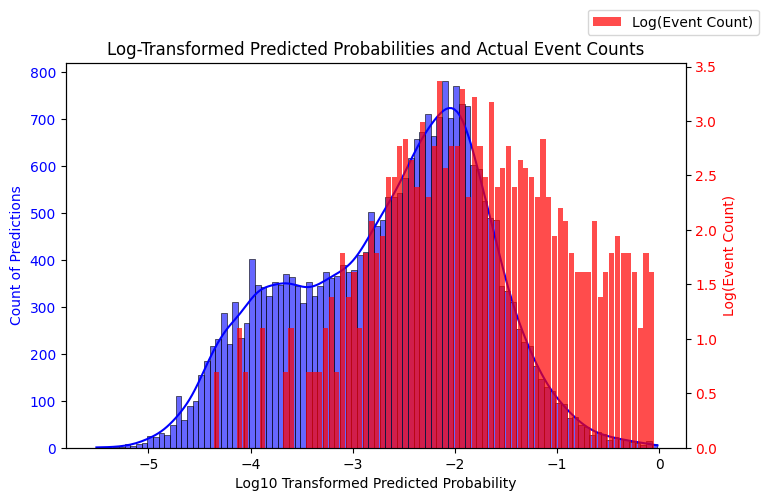

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Avoid log(0) by adding a small constant (e.g., 1e-6)
output_df['Log Predicted Probability'] = np.log10(output_df['Predicted Probability'] + 1e-6)

# Define bins for log-transformed predicted probabilities
log_bins = np.linspace(output_df['Log Predicted Probability'].min(), output_df['Log Predicted Probability'].max(), 99)

# Compute event count per bin based on log-transformed predicted probability
event_counts, _ = np.histogram(output_df.loc[output_df['Actual Outcome'] == 1, 'Log Predicted Probability'], bins=log_bins)

# Compute log transform of event counts (adding 1 to avoid log(0))
log_event_counts = np.log1p(event_counts)

# Plot histogram of log-transformed predicted probabilities
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.histplot(output_df['Log Predicted Probability'], bins=99, kde=True, color='blue', alpha=0.6, ax=ax1)
ax1.set_xlabel("Log10 Transformed Predicted Probability")
ax1.set_ylabel("Count of Predictions", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis for event counts (log-transformed)
ax2 = ax1.twinx()
ax2.bar(log_bins[:-1], log_event_counts, width=0.05, alpha=0.7, color='red', label='Log(Event Count)')
ax2.set_ylabel('Log(Event Count)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.title("Log-Transformed Predicted Probabilities and Actual Event Counts")
plt.show()


Plot the relationship between predicted probabilities and actual outcomes on a log scale. It plots a histogram of log-transformed predicted probabilities and overlays a line plot of the log-transformed event counts on a secondary y-axis. 

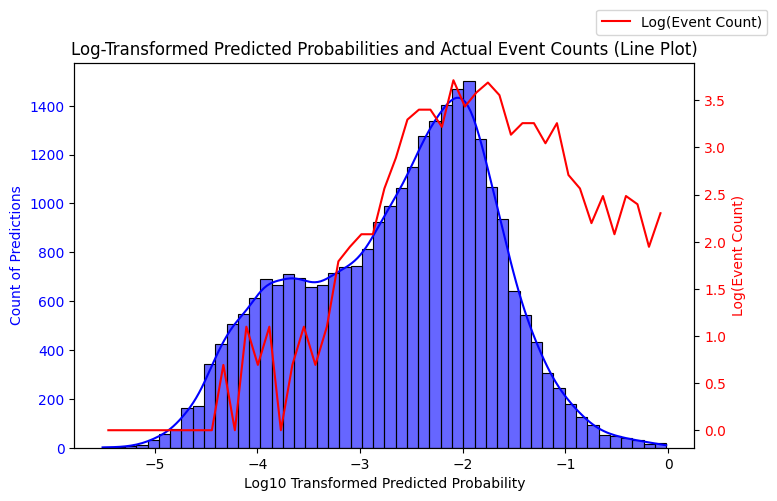

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Avoid log(0) by adding a small constant (e.g., 1e-6)
output_df['Log Predicted Probability'] = np.log10(output_df['Predicted Probability'] + 1e-6)

# Define bins for log-transformed predicted probabilities
log_bins = np.linspace(output_df['Log Predicted Probability'].min(), output_df['Log Predicted Probability'].max(), 50)

# Compute event count per bin based on log-transformed predicted probability
event_counts, _ = np.histogram(output_df.loc[output_df['Actual Outcome'] == 1, 'Log Predicted Probability'], bins=log_bins)

# Compute log transform of event counts (adding 1 to avoid log(0))
log_event_counts = np.log1p(event_counts)

# Compute bin midpoints for line plot
bin_midpoints = (log_bins[:-1] + log_bins[1:]) / 2  # Midpoints of bins

# Plot histogram of log-transformed predicted probabilities
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.histplot(output_df['Log Predicted Probability'], bins=50, kde=True, color='blue', alpha=0.6, ax=ax1)
ax1.set_xlabel("Log10 Transformed Predicted Probability")
ax1.set_ylabel("Count of Predictions", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis for event counts (log-transformed)
ax2 = ax1.twinx()
ax2.plot(bin_midpoints, log_event_counts, linestyle='-', color='red', label='Log(Event Count)')  # Line plot
ax2.set_ylabel('Log(Event Count)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.title("Log-Transformed Predicted Probabilities and Actual Event Counts (Line Plot)")
plt.show()

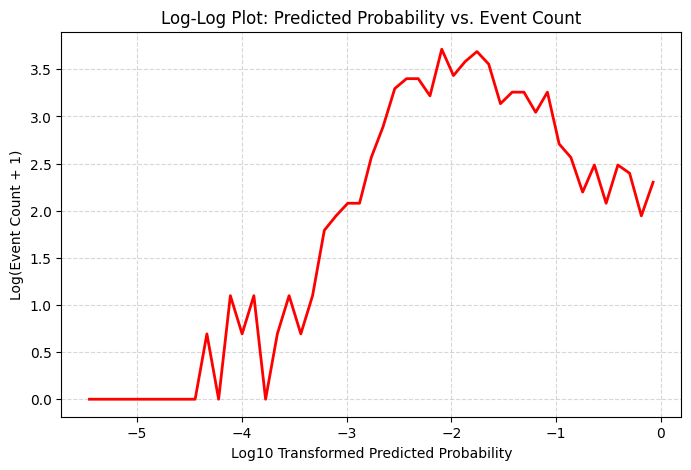

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Log-transform predicted probabilities
output_df['Log Predicted Probability'] = np.log10(output_df['Predicted Probability'] + 1e-6)

# Step 2: Create bins for log-transformed probabilities
log_bins = np.linspace(output_df['Log Predicted Probability'].min(),
                       output_df['Log Predicted Probability'].max(), 50)
bin_midpoints = (log_bins[:-1] + log_bins[1:]) / 2

# Step 3: Count events (Actual Outcome = 1) in each bin
event_counts, _ = np.histogram(
    output_df.loc[output_df['Actual Outcome'] == 1, 'Log Predicted Probability'],
    bins=log_bins
)

# Step 4: Log-transform the event counts
log_event_counts = np.log1p(event_counts)

# Step 5: Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_midpoints, log_event_counts, color='red', linewidth=2)
plt.xlabel("Log10 Transformed Predicted Probability")
plt.ylabel("Log(Event Count + 1)")
plt.title("Log-Log Plot: Predicted Probability vs. Event Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Fits a smoothing spline to the log-transformed event counts across binned predicted probabilities.

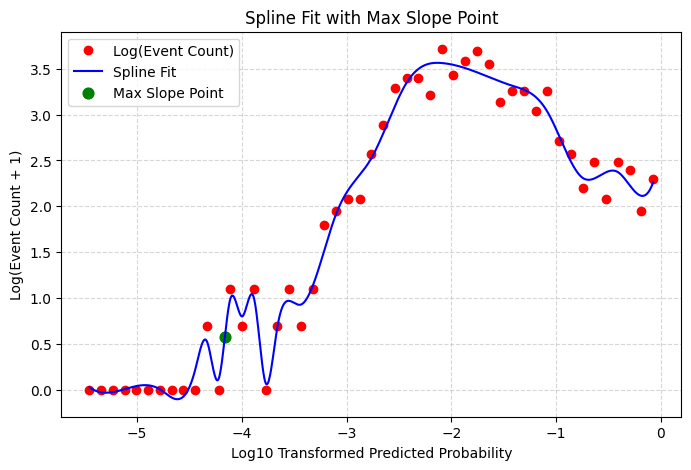

Max slope at x = -4.1607, y = 0.5742, slope ≈ 10.0689


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Fit a smoothing spline
spline = UnivariateSpline(bin_midpoints, log_event_counts, s=1)  # s controls smoothing

# Fine grid for plotting
x_fine = np.linspace(bin_midpoints.min(), bin_midpoints.max(), 1000)
y_fine = spline(x_fine)

# Compute derivative (slope)
slope_vals = spline.derivative()(x_fine)
max_slope_idx = np.argmax(slope_vals)
x_max_slope = x_fine[max_slope_idx]
y_max_slope = y_fine[max_slope_idx]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_midpoints, log_event_counts, 'ro', label='Log(Event Count)')
plt.plot(x_fine, y_fine, 'b-', label='Spline Fit')
plt.scatter(x_max_slope, y_max_slope, color='green', s=60, label='Max Slope Point')

plt.xlabel("Log10 Transformed Predicted Probability")
plt.ylabel("Log(Event Count + 1)")
plt.title("Spline Fit with Max Slope Point")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print(f"Max slope at x = {x_max_slope:.4f}, y = {y_max_slope:.4f}, slope ≈ {slope_vals[max_slope_idx]:.4f}")


Fits a single smoothing spline to the log-transformed event counts across predicted probability bins. Then splits the x-axis at -3.5 and identifies the point of maximum slope within each region by analyzing the derivative of the spline. These two max-slope points are highlighted on the plot to show where the event count increases most steeply in each wave.

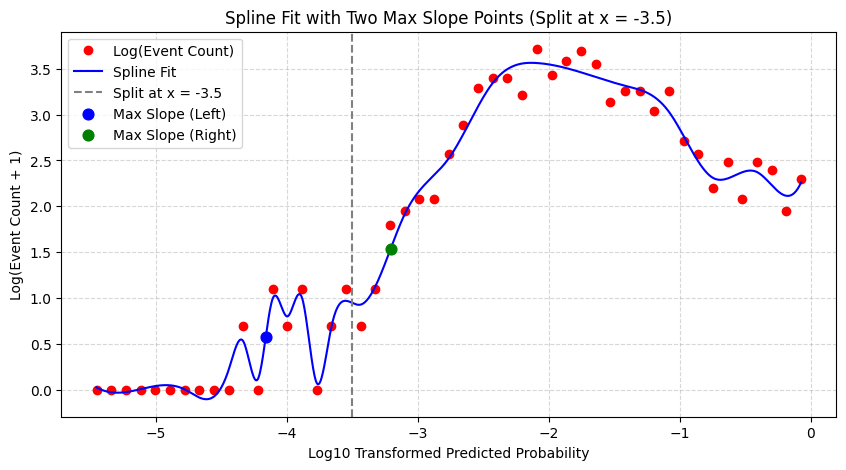

Left max slope at x = -4.1607, y = 0.5742, slope ≈ 10.0689
Right max slope at x = -3.2077, y = 1.5342, slope ≈ 3.7949


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Fit a single smoothing spline
spline = UnivariateSpline(bin_midpoints, log_event_counts, s=1)

# Evaluate on fine grid
x_fine = np.linspace(bin_midpoints.min(), bin_midpoints.max(), 1000)
y_fine = spline(x_fine)

# Compute derivative (slope)
slope_vals = spline.derivative()(x_fine)

# Split x at -3.5
split_x = -3.5
left_mask = x_fine < split_x
right_mask = x_fine >= split_x

# Find max slope points in each region
idx_left = np.argmax(slope_vals[left_mask])
x_max_left = x_fine[left_mask][idx_left]
y_max_left = y_fine[left_mask][idx_left]
slope_max_left = slope_vals[left_mask][idx_left]

idx_right = np.argmax(slope_vals[right_mask])
x_max_right = x_fine[right_mask][idx_right]
y_max_right = y_fine[right_mask][idx_right]
slope_max_right = slope_vals[right_mask][idx_right]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bin_midpoints, log_event_counts, 'ro', label='Log(Event Count)')
plt.plot(x_fine, y_fine, 'b-', label='Spline Fit')
plt.axvline(split_x, color='gray', linestyle='--', label='Split at x = -3.5')

# Highlight max slope points
plt.scatter(x_max_left, y_max_left, color='blue', s=60, zorder=5, label='Max Slope (Left)')
plt.scatter(x_max_right, y_max_right, color='green', s=60, zorder=5, label='Max Slope (Right)')

plt.xlabel("Log10 Transformed Predicted Probability")
plt.ylabel("Log(Event Count + 1)")
plt.title("Spline Fit with Two Max Slope Points (Split at x = -3.5)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Output max slope info
print(f"Left max slope at x = {x_max_left:.4f}, y = {y_max_left:.4f}, slope ≈ {slope_max_left:.4f}")
print(f"Right max slope at x = {x_max_right:.4f}, y = {y_max_right:.4f}, slope ≈ {slope_max_right:.4f}")


Convert back to original scale and use these two points as cutoff values.

In [74]:
count_x1 = inverse_log_pred(x_max_left)
count_x2 = inverse_log_pred(x_max_right)

print(f"Left peak predicted prob: {count_x1:.8f}")
print(f"Right peak predicted prob: {count_x2:.8f}")

Left peak predicted prob: 0.00006807
Right peak predicted prob: 0.00061882


In [75]:
low_cutoff = count_x1
high_cutoff = count_x2

# Step 2: Apply risk grouping based on x1/x2 thresholds
output_df['Risk Group'] = output_df['Predicted Probability'].apply(
    lambda prob: "Low Risk" if prob < low_cutoff else ("Moderate Risk" if prob < high_cutoff else "High Risk")
)

# Step 3: Count samples per group
group_counts = output_df['Risk Group'].value_counts().to_dict()

# Step 4: Count events (Actual Outcome = 1) per group
event_counts = output_df.groupby('Risk Group')['Actual Outcome'].sum().to_dict()

# Step 5: Event rate within each group
event_percentages = {
    group: (event_counts.get(group, 0) / group_counts.get(group, 1)) * 100
    for group in ["Low Risk", "Moderate Risk", "High Risk"]
}

# Step 6: Compute AUC per group (only if both classes are present)
auc_per_group = {}
for group in ["Low Risk", "Moderate Risk", "High Risk"]:
    group_df = output_df[output_df['Risk Group'] == group]
    y_true = group_df['Actual Outcome']
    
    if len(group_df) > 50 and y_true.nunique() == 2:  # Must have both 0 and 1
        auc_per_group[group] = roc_auc_score(y_true, group_df['Predicted Probability'])
    else:
        auc_per_group[group] = None


# Step 7: Weighted average AUC
valid_aucs = {group: auc for group, auc in auc_per_group.items() if auc is not None}
total_samples = sum(group_counts.values())

if valid_aucs and total_samples > 0:
    weighted_auc = sum(
        (group_counts[group] * auc_per_group[group]) for group in valid_aucs
    ) / total_samples
else:
    weighted_auc = None

# Step 8: Store results in a DataFrame
final_cutoff_result_2 = pd.DataFrame([{
    "Low Cutoff Value": low_cutoff,
    "High Cutoff Value": high_cutoff,

    "Low Risk AUC": auc_per_group["Low Risk"],
    "Low Risk Count": group_counts.get("Low Risk", 0),
    "Low Risk Event Count": event_counts.get("Low Risk", 0),
    "Low Risk Event %": event_percentages.get("Low Risk", 0),

    "Moderate Risk AUC": auc_per_group["Moderate Risk"],
    "Moderate Risk Count": group_counts.get("Moderate Risk", 0),
    "Moderate Risk Event Count": event_counts.get("Moderate Risk", 0),
    "Moderate Risk Event %": event_percentages.get("Moderate Risk", 0),

    "High Risk AUC": auc_per_group["High Risk"],
    "High Risk Count": group_counts.get("High Risk", 0),
    "High Risk Event Count": event_counts.get("High Risk", 0),
    "High Risk Event %": event_percentages.get("High Risk", 0),

    "Weighted AUC": weighted_auc
}])

# Display the results
display(final_cutoff_result_2)

,Low Cutoff Value,High Cutoff Value,Low Risk AUC,Low Risk Count,Low Risk Event Count,Low Risk Event %,Moderate Risk AUC,Moderate Risk Count,Moderate Risk Event Count,Moderate Risk Event %,High Risk AUC,High Risk Count,High Risk Event Count,High Risk Event %,Weighted AUC
0,0.000068,0.000619,0.604932,1988,1,0.050302,0.535904,5743,13,0.226363,0.676126,19477,543,2.787904,0.641326
